[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



Model Performance Metrics:
                      Accuracy  Precision    Recall  F1 Score       AUC
Logistic Regression  0.786353   0.789903  0.750277  0.769580  0.869742
Random Forest        0.756359   0.754819  0.722243  0.738172  0.835162
SVM                  0.783021   0.778534  0.759867  0.769087  0.865616


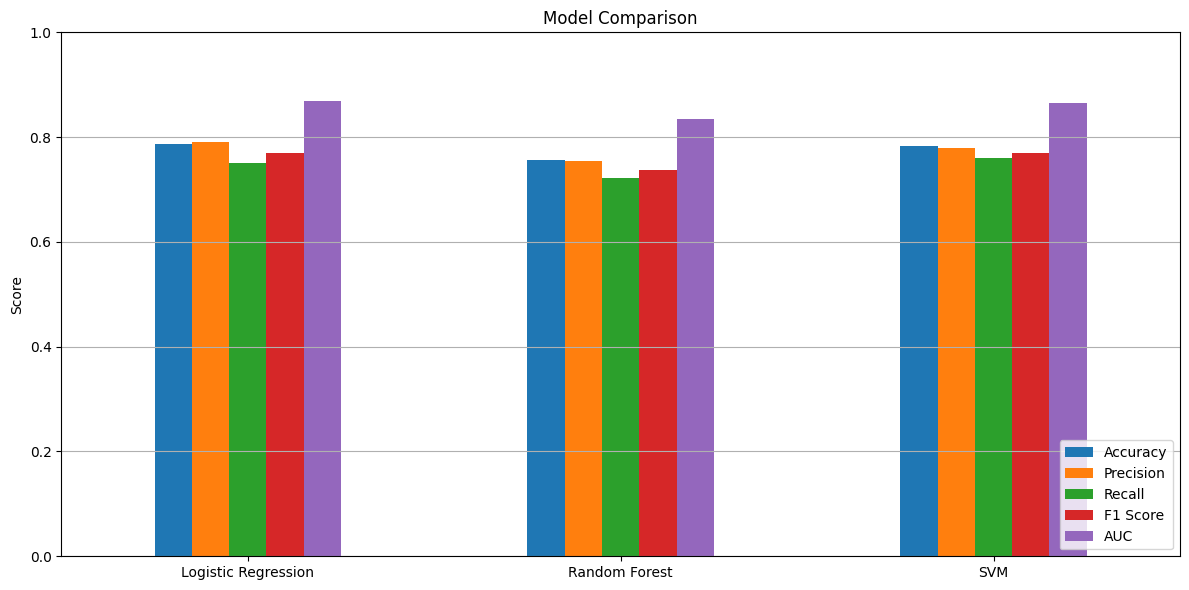

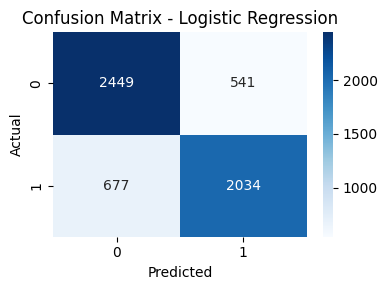

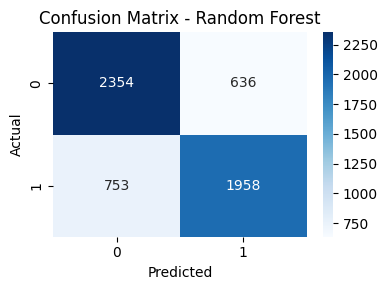

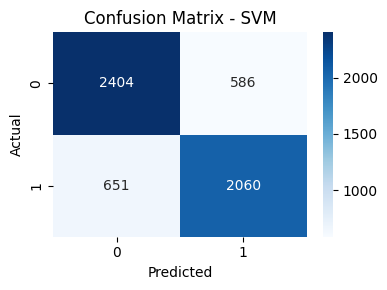

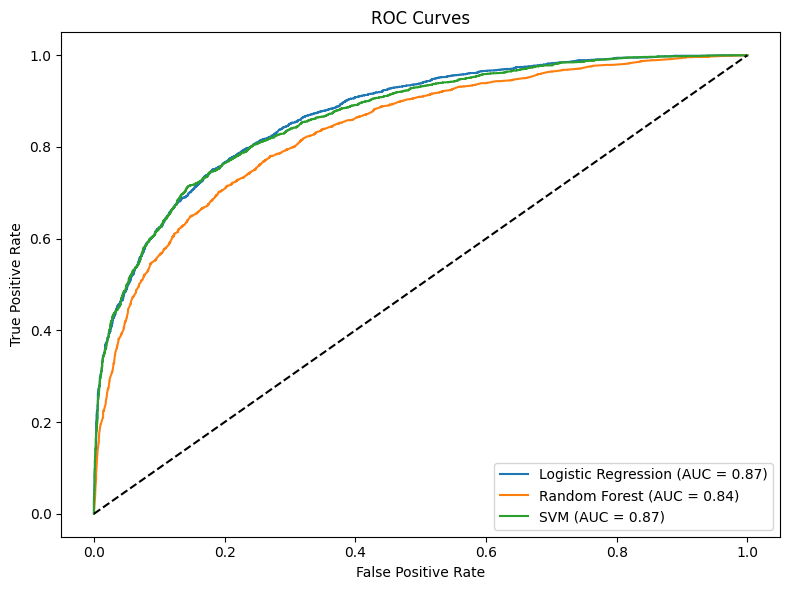

In [ ]:

import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)
nltk.download('omw-1.4', force=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df1 = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)
df2 = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)

df1['article_link'] = df1.get('article_link', None)
df1['headline'] = df1['headline'].astype(str)
df2['headline'] = df2['headline'].astype(str)

df = pd.concat([df1, df2], ignore_index=True)
df.drop_duplicates(subset='headline', inplace=True)
df.dropna(subset=['headline'], inplace=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and w.isalpha()]
    return " ".join(tokens)

df['clean'] = df['headline'].apply(preprocess)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean'])
y = df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear', probability=True)
}

results = {}
conf_matrices = {}
roc_curves = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    }

    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    roc_curves[name] = roc_curve(y_test, y_prob)

metrics_df = pd.DataFrame(results).T
print("\nModel Performance Metrics:\n", metrics_df)

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

for name, matrix in conf_matrices.items():
    plt.figure(figsize=(4,3))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8,6))
for name, (fpr, tpr, _) in roc_curves.items():
    auc = results[name]['AUC']
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()
